# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load the Dataset

In [0]:
import tensorflow as tf
import tensorflow_datasets 

In [0]:
imdb, info=tensorflow_datasets.load("imdb_reviews", with_info=True, as_supervised=True)

In [48]:
imdb

{'test': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>,
 'train': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>,
 'unsupervised': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>}

In [49]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

# Training and Testing Data

In [0]:
train_data, test_data=imdb['train'], imdb['test']

training_sentences=[]
training_label=[]

testing_sentences=[]
testing_label=[]

In [0]:
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_label.append(l.numpy())

for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_label.append(l.numpy())

training_label_final=np.array(training_label)
testing_label_final=np.array(testing_label)

# Tokenization and Padding

In [0]:
vocab_size=10000
embedding_dim=16
max_length=120
trunc_type='post'
oov_tok='<oov>'

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer= Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index=tokenizer.word_index
sequences=tokenizer.texts_to_sequences(training_sentences)
padded=pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences=tokenizer.texts_to_sequences(testing_sentences)
testing_padded=pad_sequences(testing_sequences, maxlen=max_length)

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding


# Multi-layer Bidirectional LSTM  

In [56]:
from tensorflow.keras.layers import Bidirectional, LSTM
model = Sequential()

model.add(Embedding(vocab_size,embedding_dim, input_length=max_length))

model.add(Bidirectional(LSTM(64, return_sequences=True)))

model.add(Bidirectional(LSTM(32)))

model.add(Dense(units=24,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=10,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1,activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 120, 128)          41472     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_9 (Dense)              (None, 24)                1560      
_________________________________________________________________
dropout_6 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                250       
_________________________________________________________________
dropout_7 (Dropout)          (None, 10)               

In [0]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [58]:
model.fit(x=padded, y=training_label_final, batch_size=256, epochs=100, validation_data=(testing_padded, testing_label_final), verbose=1, callbacks=[early_stop])

Epoch 1/100
98/98 [==============================] - 6s 58ms/step - loss: 0.6931 - accuracy: 0.5005 - val_loss: 0.6929 - val_accuracy: 0.5250
Epoch 2/100
98/98 [==============================] - 5s 47ms/step - loss: 0.6924 - accuracy: 0.5212 - val_loss: 0.6911 - val_accuracy: 0.5878
Epoch 3/100
98/98 [==============================] - 5s 47ms/step - loss: 0.6539 - accuracy: 0.6304 - val_loss: 0.5516 - val_accuracy: 0.7576
Epoch 4/100
98/98 [==============================] - 5s 51ms/step - loss: 0.5395 - accuracy: 0.7557 - val_loss: 0.4385 - val_accuracy: 0.8117
Epoch 5/100
98/98 [==============================] - 5s 47ms/step - loss: 0.4684 - accuracy: 0.8051 - val_loss: 0.3911 - val_accuracy: 0.8301
Epoch 6/100
98/98 [==============================] - 5s 48ms/step - loss: 0.4220 - accuracy: 0.8384 - val_loss: 0.3708 - val_accuracy: 0.8400
Epoch 7/100
98/98 [==============================] - 5s 48ms/step - loss: 0.3826 - accuracy: 0.8590 - val_loss: 0.3590 - val_accuracy: 0.8424
Epoch 

In [59]:
df_lstm=pd.DataFrame(model.history.history)
df_lstm['Epoch']=range(1,13)
df_lstm.index=df_lstm['Epoch']
df_lstm

,loss,accuracy,val_loss,val_accuracy,Epoch
Epoch,,,,,
1,0.693133,0.50048,0.692940,0.52500,1
2,0.692442,0.52124,0.691069,0.58776,2
3,0.653876,0.63044,0.551588,0.75760,3
4,0.539474,0.75572,0.438481,0.81168,4
5,0.468417,0.80508,0.391061,0.83012,5
6,0.421962,0.83840,0.370768,0.83996,6
7,0.382585,0.85900,0.359048,0.84240,7
8,0.355519,0.87244,0.360275,0.84300,8
9,0.331753,0.88316,0.400393,0.84000,9


In [60]:
score_lstm = model.evaluate(testing_padded, testing_label_final, batch_size=64, verbose=1)
print('Test accuracy:', score_lstm[1])

391/391 [==============================] - 4s 10ms/step - loss: 0.4204 - accuracy: 0.8389
Test accuracy: 0.838919997215271


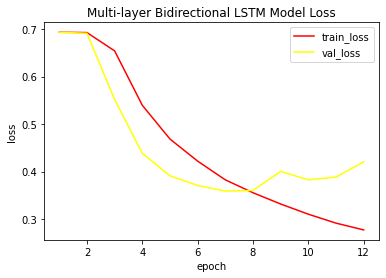

In [61]:
#Loss Graph - Multi-layer Bidirectional LSTM (Training and Validation)
plt.plot(df_lstm['loss'], color='red')
plt.plot(df_lstm['val_loss'], color='yellow')
plt.title('Multi-layer Bidirectional LSTM Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

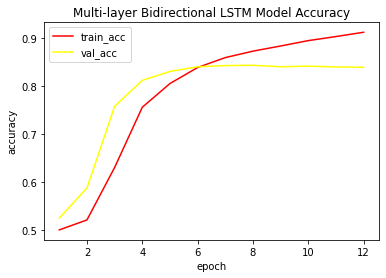

In [62]:
# Accuracy Graph - Multi-layer Bidirectional LSTM (Training and Validation) 
plt.plot(df_lstm['accuracy'], color='red')
plt.plot(df_lstm['val_accuracy'], color='yellow')
plt.title('Multi-layer Bidirectional LSTM Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'])
plt.show()

# 1D Convolution 

In [63]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
model_conv = Sequential()

model_conv.add(Embedding(vocab_size,embedding_dim, input_length=max_length))

model_conv.add(Conv1D(128, 5, activation='relu'))
model_conv.add(GlobalMaxPooling1D())

model_conv.add(Dense(units=24,activation='relu'))
model_conv.add(Dropout(0.5))

model_conv.add(Dense(units=10,activation='relu'))
model_conv.add(Dropout(0.5))

model_conv.add(Dense(units=1,activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_conv.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model_conv.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 24)                3096      
_________________________________________________________________
dropout_8 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                250       
_________________________________________________________________
dropout_9 (Dropout)          (None, 10)               

In [64]:
model_conv.fit(x=padded, y=training_label_final, batch_size=256, epochs=100, validation_data=(testing_padded, testing_label_final), verbose=1, callbacks=[early_stop])

Epoch 1/100
98/98 [==============================] - 1s 14ms/step - loss: 0.6934 - accuracy: 0.4995 - val_loss: 0.6929 - val_accuracy: 0.5204
Epoch 2/100
98/98 [==============================] - 1s 10ms/step - loss: 0.6929 - accuracy: 0.5057 - val_loss: 0.6927 - val_accuracy: 0.5321
Epoch 3/100
98/98 [==============================] - 1s 10ms/step - loss: 0.6920 - accuracy: 0.5179 - val_loss: 0.6921 - val_accuracy: 0.5586
Epoch 4/100
98/98 [==============================] - 1s 10ms/step - loss: 0.6914 - accuracy: 0.5292 - val_loss: 0.6911 - val_accuracy: 0.6012
Epoch 5/100
98/98 [==============================] - 1s 10ms/step - loss: 0.6897 - accuracy: 0.5499 - val_loss: 0.6889 - val_accuracy: 0.6570
Epoch 6/100
98/98 [==============================] - 1s 11ms/step - loss: 0.6869 - accuracy: 0.5690 - val_loss: 0.6845 - val_accuracy: 0.6781
Epoch 7/100
98/98 [==============================] - 1s 10ms/step - loss: 0.6801 - accuracy: 0.6001 - val_loss: 0.6752 - val_accuracy: 0.7103
Epoch 

In [65]:
df_conv1D=pd.DataFrame(model_conv.history.history)
df_conv1D['Epoch']=range(1,31)
df_conv1D.index=df_conv1D['Epoch']
df_conv1D

,loss,accuracy,val_loss,val_accuracy,Epoch
Epoch,,,,,
1,0.693423,0.49948,0.692945,0.52040,1
2,0.692916,0.50572,0.692682,0.53208,2
3,0.691967,0.51788,0.692111,0.55856,3
4,0.691417,0.52916,0.691126,0.60120,4
5,0.689704,0.54992,0.688933,0.65700,5
6,0.686874,0.56904,0.684488,0.67808,6
7,0.680114,0.60012,0.675235,0.71032,7
8,0.669086,0.61800,0.657797,0.71664,8
9,0.652082,0.63424,0.630687,0.73828,9


In [66]:
score_conv1D = model_conv.evaluate(testing_padded, testing_label_final, batch_size=64, verbose=1)
print('Test accuracy:', score_conv1D[1])

391/391 [==============================] - 1s 2ms/step - loss: 0.3939 - accuracy: 0.8298
Test accuracy: 0.829800009727478


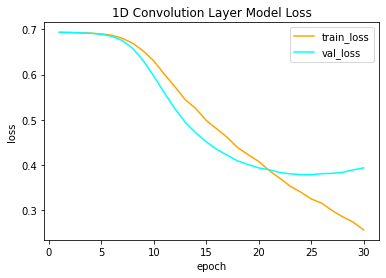

In [67]:
#Loss Graph - 1D Convolution (Training and Validation)
plt.plot(df_conv1D['loss'], color='orange')
plt.plot(df_conv1D['val_loss'], color='cyan')
plt.title('1D Convolution Layer Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

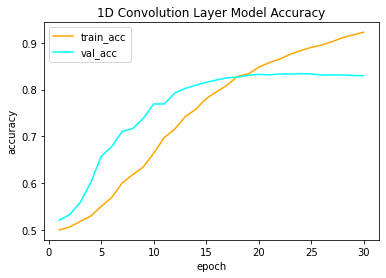

In [68]:
# Accuracy Graph - 1D Convolution (Training and Validation) 
plt.plot(df_conv1D['accuracy'], color='orange')
plt.plot(df_conv1D['val_accuracy'], color='cyan')
plt.title('1D Convolution Layer Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'])
plt.show()

# Gated recurrent unit (GRU)

In [69]:
from tensorflow.keras.layers import GRU
model_gru = Sequential()

model_gru.add(Embedding(vocab_size,embedding_dim, input_length=max_length))

model_gru.add(Bidirectional(GRU(64)))

model_gru.add(Dense(units=24,activation='relu'))
model_gru.add(Dropout(0.5))

model_gru.add(Dense(units=10,activation='relu'))
model_gru.add(Dropout(0.5))

model_gru.add(Dense(units=1,activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_gru.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model_gru.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 128)               31488     
_________________________________________________________________
dense_15 (Dense)             (None, 24)                3096      
_________________________________________________________________
dropout_10 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                250       
_________________________________________________________________
dropout_11 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

In [70]:
model_gru.fit(x=padded, y=training_label_final, batch_size=256, epochs=100, validation_data=(testing_padded, testing_label_final), verbose=1, callbacks=[early_stop])

Epoch 1/100
98/98 [==============================] - 3s 31ms/step - loss: 0.6931 - accuracy: 0.5007 - val_loss: 0.6930 - val_accuracy: 0.5132
Epoch 2/100
98/98 [==============================] - 2s 25ms/step - loss: 0.6930 - accuracy: 0.5096 - val_loss: 0.6929 - val_accuracy: 0.5176
Epoch 3/100
98/98 [==============================] - 3s 26ms/step - loss: 0.6928 - accuracy: 0.5124 - val_loss: 0.6927 - val_accuracy: 0.5138
Epoch 4/100
98/98 [==============================] - 2s 25ms/step - loss: 0.6926 - accuracy: 0.5111 - val_loss: 0.6925 - val_accuracy: 0.5273
Epoch 5/100
98/98 [==============================] - 2s 25ms/step - loss: 0.6917 - accuracy: 0.5268 - val_loss: 0.6916 - val_accuracy: 0.5417
Epoch 6/100
98/98 [==============================] - 2s 25ms/step - loss: 0.6886 - accuracy: 0.5531 - val_loss: 0.6859 - val_accuracy: 0.5755
Epoch 7/100
98/98 [==============================] - 3s 26ms/step - loss: 0.6241 - accuracy: 0.6654 - val_loss: 0.5123 - val_accuracy: 0.7888
Epoch 

In [71]:
df_gru=pd.DataFrame(model_gru.history.history)
df_gru['Epoch']=range(1,18)
df_gru.index=df_gru['Epoch']
df_gru

,loss,accuracy,val_loss,val_accuracy,Epoch
Epoch,,,,,
1,0.693126,0.50072,0.693023,0.51316,1
2,0.692992,0.50960,0.692884,0.51756,2
3,0.692798,0.51236,0.692715,0.51376,3
4,0.692611,0.51112,0.692482,0.52728,4
5,0.691710,0.52684,0.691557,0.54172,5
6,0.688563,0.55308,0.685861,0.57548,6
7,0.624094,0.66536,0.512277,0.78876,7
8,0.511589,0.76512,0.415949,0.82652,8
9,0.448217,0.80476,0.387551,0.83872,9


In [72]:
score_gru = model_gru.evaluate(testing_padded, testing_label_final, batch_size=64, verbose=1)
print('Test accuracy:', score_gru[1])

391/391 [==============================] - 3s 6ms/step - loss: 0.3836 - accuracy: 0.8410
Test accuracy: 0.8410400152206421


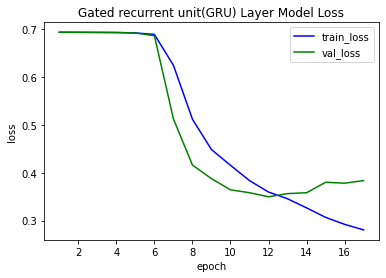

In [73]:
#Loss Graph - Gated recurrent unit(GRU)(Training and Validation)
plt.plot(df_gru['loss'], color='blue')
plt.plot(df_gru['val_loss'], color='green')
plt.title('Gated recurrent unit(GRU) Layer Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

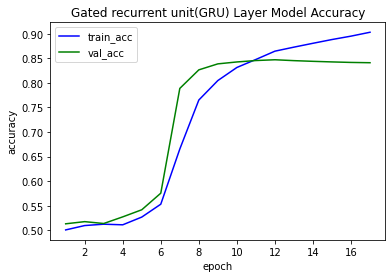

In [74]:
# Accuracy Graph - Gated recurrent unit(GRU)(Training and Validation) 
plt.plot(df_gru['accuracy'], color='blue')
plt.plot(df_gru['val_accuracy'], color='green')
plt.title('Gated recurrent unit(GRU) Layer Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'])
plt.show()